# Self-Driving Car Engineer Nanodegree


## Project: **Car Tracking** 
---

## Ideas for Lane Detection Pipeline

- Gather the Dataset
- Decide on which features to use
- Create Classifier and Train it
- Use sliding window technique to search for vehicles in a frame
- Tune to reduce false positives and improve tracking

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.externals import joblib
%matplotlib inline

#Enable this variable to enable visualization 
display = True #False
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

## Reading the Data Set

In [4]:
cars = []
notcars = []
#images = glob.glob('./small_data/*/*/*.jpeg')
images = glob.glob('./big_data/*/*/*.png')
for image in images:
    #if 'image' in image or 'extra' in image:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars),len(notcars))

8792 8968


## Feature extraction from Images

In [6]:
#TODO combines both features- normalize and stuff to check what to do
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    
    return features
    
        



## Classifier

In [7]:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
ts=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
#Trained with color_space = 'YCrCb', orient = 9, pix_per_cell = 8,cell_per_block = 2,hog_channel = 1, 
#spatial_size = (16, 16), hist_bins = 16 and spat, hist and hog true
#filename = './large_data_train.joblib.pkl'

#Trained with color_space = 'YCrCb', orient = 9, pix_per_cell = 8,cell_per_block = 2,hog_channel = 1, 
#spatial_size = (16, 16), hist_bins = 16 and spat, hist and hog true
filename = './large_data_alltrain.joblib.pkl'

_ = joblib.dump(svc, filename, compress=9)

    
""" # Not wokring good! training time is 20 times higher than LinearSVC
parameters = {'kernel':['linear'], 'C':[1]}
svr = svm.SVC()
svc = grid_search.GridSearchCV(svr, parameters)
svc.fit(X_train, y_train)
print(svc.best_params_)
"""


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t2-ts, 2), 'create features and train')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print(round(t-t2, 5), 'single sample...')

/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
84.75 Seconds to train SVC...
376.51 create features and train
Test Accuracy of SVC =  0.9887
0.07419 single sample...


# code


In [8]:
#filename = './large_data_train.joblib.pkl'
filename = './large_data_alltrain.joblib.pkl'
svc2 = joblib.load(filename)
print('Test Accuracy of SVC = ', round(svc2.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9887


## Functions to Track Cars from Video

## Sliding Window for Searching Cars

In [58]:
#See that features here are same as features used in training
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel):
    
    once = True
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch2 = ctrans_tosearch[:,:,hog_channel]  # Choosing hog_channel = 1 if not all 
    

    # Define blocks and steps as above #Below 2 moved inside to accomodate more types of cells in image
    #nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    for win_size in [1,2,4]:
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64*win_size
        pix_per_cell = pix_per_cell*win_size
        nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        print('vals::',window,pix_per_cell,nblocks_per_window,cells_per_step,nxsteps,nysteps,nxblocks,nyblocks)

        # Compute individual channel HOG features for the entire image
        if hog_channel == "ALL":
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch

                if(hog_channel == "ALL"):
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat2))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                if(once == True):
                    print('size::::',np.hstack((spatial_features, hist_features, hog_features)).size)
                    once = False
                
                # Scale features and make a prediction
                
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
                
                    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                if win_size== 1:
                    draw_color = (0,0,0) 
                elif win_size== 2:
                    draw_color = (0,0,0) 
                else:
                    draw_color = (255,0,0) 
                

                if test_prediction == 0:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),draw_color,4) 

                
    return draw_img


## Build Heatmap and remove false positives

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Test on Single Image - Pipeline


vals:: 64 8 7 2 49 7 105 21
size:::: 6108


/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


vals:: 128 16 7 2 22 1 52 10
vals:: 256 64 3 2 4 -1 12 1


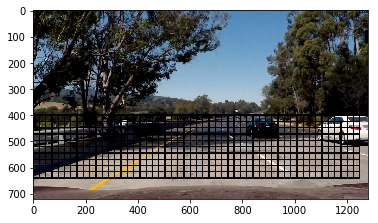

In [57]:
# code
ystart = 400
ystop = 670
scale = 1.5

if(hog_channel == "ALL"):
    filename = './large_data_alltrain.joblib.pkl'
else:
    filename = './large_data_train.joblib.pkl'
    
svc2 = joblib.load(filename)
    
im = mpimg.imread("./test_images/test5.jpg").astype(np.float32)/255
out_img = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)

plt.imshow(out_img)


## Test on Videos


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


### Pipeline to process the images from video

In [ ]:
def process_image(image):
    
    return None


Let's try the one with the solid white lane on the right first ...

In [ ]:
#Video Processing
clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
white_output = 'm_out_project_video.mp4'

#clip1 = VideoFileClip("project_video.mp4")
#white_output = 'out_project_video.mp4'

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


In [ ]:
#Challenge Video Clip
white_output = 'out_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!